# Lockdown impact and approximate test complexity by years

The main idea of this research is to predict, based on the 2018 data, what the average scores of students in the following years would be if they took the same test in 2018, which will allow us to see whether there is any difference in the difficulty of the test and the impact of COVID in certain years.

In [51]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
zno = pd.read_csv('zno_preprocessed.csv')

C:\Users\Уляна\AppData\Local\Temp\ipykernel_18748\467119846.py:1: DtypeWarning: Columns (83,84,85,86,87,88,102) have mixed types. Specify dtype option on import or set low_memory=False.
  zno = pd.read_csv('zno_preprocessed.csv')


In [3]:
zno2 = zno[['year', 'tertypename','regtypename', 'birth', 'sextypename', 'regname', 'areaname', 'tername','eoname', 'ukrtest', 'ukrteststatus', 'ukrball', 'histtest', 'histteststatus', 'histball',
     'mathtest','mathteststatus', 'mathball','phystest', 'physteststatus','physball' ,'chemtest', 'chemteststatus','chemball','biotest','bioteststatus','bioball',
    'geotest', 'geoteststatus','geoball', 'engtest', 'engteststatus', 'engball', 'deutest', 'deuteststatus','deuball', 'fratest', 'frateststatus', 'fraball','spatest', 
    'spateststatus', 'spaball']]
zno2['eoname'].fillna('інше', inplace=True)

# Ukrainian

In [17]:
zno_ukr = zno2[['year', 'tertypename', 'eoname','regtypename', 'birth', 'sextypename', 'regname', 'ukrtest', 'ukrteststatus', 'ukrball']]
zno_ukr=zno_ukr.dropna(axis='rows')
#zno_ukr.sort_values(by='ukrball', inplace=True)
zno_ukr = zno_ukr[zno_ukr['ukrball'] != 0.0] 
zno_ukr = zno_ukr.replace('селище, село', 'село')
zno_ukr.loc[zno_ukr['tertypename'] != 'місто', 'tertypename'] = 'село'

In [18]:
zno_ukr.loc[zno_ukr["year"] == 2018, 'ukrball'] = zno_ukr.loc[zno_ukr["year"] == 2018]['ukrball']/ (zno_ukr.loc[zno_ukr["year"] == 2018]['ukrball']).max()
zno_ukr.loc[zno_ukr["year"] == 2019, 'ukrball'] = zno_ukr.loc[zno_ukr["year"] == 2019]['ukrball']/ (zno_ukr.loc[zno_ukr["year"] == 2019]['ukrball']).max()
zno_ukr.loc[zno_ukr["year"] == 2020, 'ukrball'] = zno_ukr.loc[zno_ukr["year"] == 2020]['ukrball']/ (zno_ukr.loc[zno_ukr["year"] == 2020]['ukrball']).max()
zno_ukr.loc[zno_ukr["year"] == 2021, 'ukrball'] = zno_ukr.loc[zno_ukr["year"] == 2021]['ukrball']/ (zno_ukr.loc[zno_ukr["year"] == 2021]['ukrball']).max()


In [19]:
zno_ukr_model = zno_ukr[['year', 'tertypename', 'eoname', 'regtypename', 
                         'birth', 'sextypename', 'regname', 'ukrteststatus', 'ukrball']]
zno_ukr_model.head()

,year,tertypename,eoname,regtypename,birth,sextypename,regname,ukrteststatus,ukrball
0,2018,село,Косоньська загальноосвітня школа І-ІІІ ступені...,Випускник української школи поточного року,2001,чоловіча,Закарпатська область,Не подолав поріг,0.144231
1,2018,місто,Броварська спеціалізована школа І-ІІІ ступенів...,Випускник української школи поточного року,2001,жіноча,Київська область,Зараховано,0.836538
2,2018,місто,Харківська гімназія № 12 Харківської міської р...,Випускник української школи поточного року,2000,жіноча,Харківська область,Зараховано,0.846154
3,2018,місто,Млинівська загальноосвітня школа І-ІІІ ступені...,Випускник української школи поточного року,2000,чоловіча,Рівненська область,Зараховано,0.326923
4,2018,місто,Державний професійно-технічний навчальний закл...,Випускник коледжу,1999,чоловіча,Рівненська область,Зараховано,0.250000


In [20]:
labelencoder = LabelEncoder()
zno_ukr_model[['tertypename', 'eoname', 
               'regtypename','sextypename', 
               'regname', 'ukrteststatus']] = zno_ukr_model[['tertypename', 'eoname', 
               'regtypename','sextypename', 
               'regname', 'ukrteststatus']].apply(LabelEncoder().fit_transform)

In [21]:
df_ukr_2018 = zno_ukr_model[(zno_ukr_model['year'] == 2018)]

ukr_x_train,ukr_x_test, ukr_y_train, ukr_y_test = train_test_split(df_ukr_2018.drop('ukrball', axis=1), df_ukr_2018['ukrball'], random_state=42, train_size=0.7)


In [22]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [23]:
rf=RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(ukr_x_train, ukr_y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, verbose=2)

In [24]:
rf_random.best_estimator_

RandomForestRegressor(max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=400)

In [52]:
best_random_ukr = RandomForestRegressor(max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=400)
best_random_ukr.fit(df_ukr_2018.drop('ukrball', axis=1), df_ukr_2018['ukrball'])

C:\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=400)

In [55]:
df_ukr_2019 = zno_ukr_model[(zno_ukr_model['year'] == 2019)]
df_ukr_2020 = zno_ukr_model[(zno_ukr_model['year'] == 2020)]
df_ukr_2021 = zno_ukr_model[(zno_ukr_model['year'] == 2021)]

In [56]:
y_pred_2019 = best_random_ukr.predict(df_ukr_2019.drop('ukrball', axis=1))
y_pred_2020 = best_random_ukr.predict(df_ukr_2020.drop('ukrball', axis=1))
y_pred_2021 = best_random_ukr.predict(df_ukr_2021.drop('ukrball', axis=1))

In [57]:
ukr_2019 = pd.concat([df_ukr_2019['ukrball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2019)],axis=1)
ukr_2020 = pd.concat([df_ukr_2020['ukrball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2020)],axis=1)
ukr_2021 = pd.concat([df_ukr_2021['ukrball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2021)],axis=1)


In [61]:
np.array(df_ukr_2019['ukrball'])

array([0.22115385, 0.65384615, 0.36538462, ..., 0.33653846, 0.40384615,
       0.38461538])

In [65]:
print(f"Percentage error for 2019 year {mean_absolute_percentage_error(np.array(df_ukr_2019['ukrball']), y_pred_2019)*100}")
print(f"Percentage error for 2020 year {mean_absolute_percentage_error(np.array(df_ukr_2020['ukrball']), y_pred_2020)*100}")
print(f"Percentage error for 2021 year {mean_absolute_percentage_error(np.array(df_ukr_2021['ukrball']), y_pred_2021)*100}") 

Percentage error for 2019 year 30.64719077877502
Percentage error for 2020 year 33.4686449116917
Percentage error for 2021 year 30.98072256317556


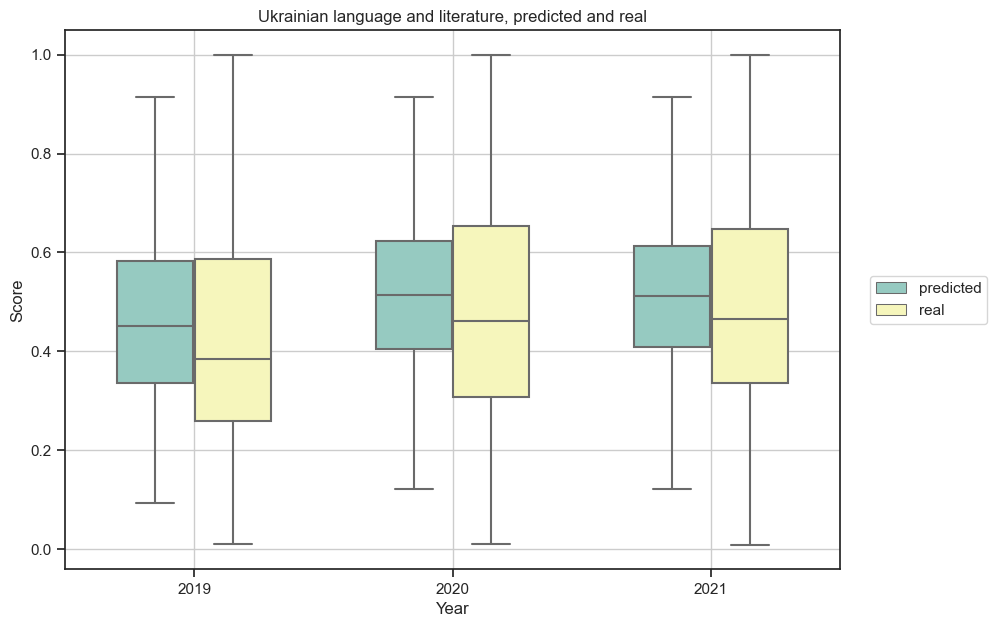

In [66]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



# merge the three dataframes into a single dataframe
df = pd.concat([ukr_2019, ukr_2020, ukr_2021], axis=0).rename(columns={'ukrball':'real', 0:'predicted'})
df['Year'] = ['2019']*len(ukr_2019) + ['2020']*len(ukr_2020) + ['2021']*len(ukr_2021)

# melt the dataframe to make it "tidy"
df_melt = pd.melt(df, id_vars=['Year'], value_vars=['predicted', 'real'], var_name='Type', value_name='Score')
fig = plt.figure(figsize =(10, 7))
# create the boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x='Year', y='Score', hue='Type', data=df_melt, palette='Set3', width=0.6)
# Move the hue legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

# customize the plot
plt.title("Ukrainian language and literature, predicted and real")
plt.grid(True)

# show the plot
plt.show()
# Draw a nested boxplot to show bills by day and time



When comparing the predicted distribution and the actual values in a given year, the difference between the median values of the Ukrainian language test remains the same, which does not allow us to say that the lockdown affected any teaching of the Ukrainian language or that the tests were of different complexity.

# Math

In [4]:
zno_math = zno2[['year', 'tertypename', 'eoname','regtypename', 
                 'birth', 'sextypename', 'regname', 'mathtest', 'mathteststatus', 'mathball']]
zno_math=zno_math.dropna(axis='rows')
zno_math = zno_math[zno_math['mathball'] != 0.0] 
zno_math = zno_math.replace('селище, село', 'село')
zno_math.loc[zno_math['tertypename'] != 'місто', 'tertypename'] = 'село'

In [5]:
zno_math.loc[zno_math["year"] == 2018, 'mathball'] = zno_math.loc[zno_math["year"] == 2018]['mathball']/ (zno_math.loc[zno_math["year"] == 2018]['mathball']).max()
zno_math.loc[zno_math["year"] == 2019, 'mathball'] = zno_math.loc[zno_math["year"] == 2019]['mathball']/ (zno_math.loc[zno_math["year"] == 2019]['mathball']).max()
zno_math.loc[zno_math["year"] == 2020, 'mathball'] = zno_math.loc[zno_math["year"] == 2020]['mathball']/ (zno_math.loc[zno_math["year"] == 2020]['mathball']).max()
zno_math.loc[zno_math["year"] == 2021, 'mathball'] = zno_math.loc[zno_math["year"] == 2021]['mathball']/ (zno_math.loc[zno_math["year"] == 2021]['mathball']).max()


In [6]:
zno_math_model = zno_math[['year', 'tertypename', 'eoname', 'regtypename', 
                         'birth', 'sextypename', 'regname', 'mathteststatus', 'mathball']]
zno_math_model.head()

,year,tertypename,eoname,regtypename,birth,sextypename,regname,mathteststatus,mathball
3,2018,місто,Млинівська загальноосвітня школа І-ІІІ ступені...,Випускник української школи поточного року,2000,чоловіча,Рівненська область,Зараховано,0.193548
7,2018,село,Стеблівська загальноосвітня школа І-ІІІ ступен...,Випускник української школи поточного року,2001,чоловіча,Закарпатська область,Зараховано,0.177419
8,2018,місто,Вознесенський професійний ліцей,Випускник коледжу,2000,жіноча,Миколаївська область,Не подолав поріг,0.096774
11,2018,місто,Новоград-Волинська загальноосвітня школа І-ІІІ...,Випускник української школи поточного року,2000,жіноча,Житомирська область,Зараховано,0.435484
22,2018,місто,інше,Випускник минулих років,1998,чоловіча,Запорізька область,Зараховано,0.258065


In [7]:
zno_math_model[['tertypename', 'eoname', 
               'regtypename','sextypename', 
               'regname', 'mathteststatus']] = zno_math_model[['tertypename', 'eoname', 
               'regtypename','sextypename', 
               'regname', 'mathteststatus']].apply(LabelEncoder().fit_transform)

In [9]:
df_math_2018 = zno_math_model[(zno_math_model['year'] == 2018)]

math_x_train,math_x_test, math_y_train, math_y_test = train_test_split(df_math_2018.drop('mathball', axis=1), df_math_2018['mathball'], random_state=42, train_size=0.7)


In [10]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [11]:
rf_m=RandomForestRegressor()
rf_random_m = RandomizedSearchCV(estimator = rf_m, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_m.fit(math_x_train, math_y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, verbose=2)

In [13]:
rf_random_m.best_estimator_

RandomForestRegressor(max_depth=60, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=450)

In [67]:
best_random_m = RandomForestRegressor(max_depth=60, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=450)
best_random_m.fit(df_math_2018.drop('mathball', axis=1), df_math_2018['mathball'])

C:\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=60, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=450)

In [68]:
df_math_2019 = zno_math_model[(zno_math_model['year'] == 2019)]
df_math_2020 = zno_math_model[(zno_math_model['year'] == 2020)]
df_math_2021 = zno_math_model[(zno_math_model['year'] == 2021)]

In [69]:
y_pred_2019_m = best_random_m.predict(df_math_2019.drop('mathball', axis=1))
y_pred_2020_m = best_random_m.predict(df_math_2020.drop('mathball', axis=1))
y_pred_2021_m = best_random_m.predict(df_math_2021.drop('mathball', axis=1))

In [70]:
math_2019 = pd.concat([df_math_2019['mathball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2019_m)],axis=1)
math_2020 = pd.concat([df_math_2020['mathball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2020_m)],axis=1)
math_2021 = pd.concat([df_math_2021['mathball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2021_m)],axis=1)


In [76]:
print(f"Percentage error for 2019 year {mean_absolute_percentage_error(np.array(df_math_2019['mathball']), y_pred_2019_m)*100}")
print(f"Percentage error for 2020 year {mean_absolute_percentage_error(np.array(df_math_2020['mathball']), y_pred_2020_m)*100}")
print(f"Percentage error for 2021 year {mean_absolute_percentage_error(np.array(df_math_2021['mathball']), y_pred_2021_m)*100}")

Percentage error for 2019 year 35.82565055578521
Percentage error for 2020 year 52.758723320667656
Percentage error for 2021 year 53.23301185857511


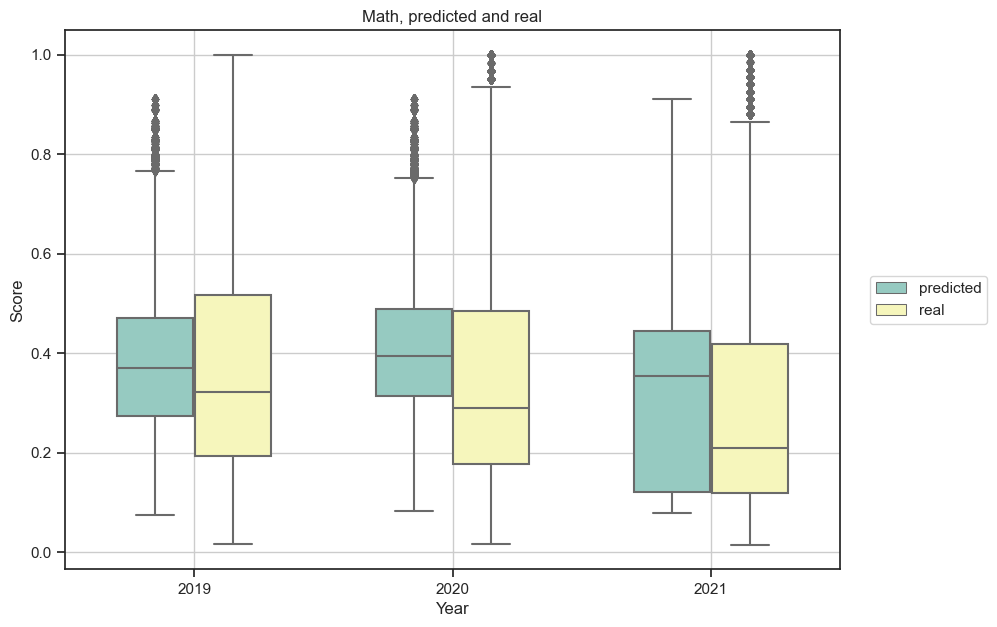

In [72]:

# merge the three dataframes into a single dataframe
df_m = pd.concat([math_2019, math_2020, math_2021], axis=0).rename(columns={'mathball':'real', 0:'predicted'})
df_m['Year'] = ['2019']*len(math_2019) + ['2020']*len(math_2020) + ['2021']*len(math_2021)

# melt the dataframe to make it "tidy"
df_melt_m = pd.melt(df_m, id_vars=['Year'], value_vars=['predicted', 'real'], var_name='Type', value_name='Score')
fig = plt.figure(figsize =(10, 7))
# create the boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x='Year', y='Score', hue='Type', data=df_melt_m, palette='Set3', width=0.6)
# Move the hue legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

# customize the plot
plt.title("Math, predicted and real")
plt.grid(True)

# show the plot
plt.show()
# Draw a nested boxplot to show bills by day and time



When comparing the predicted distribution and the actual values in a given year, the difference between the median values of the math test changes very significantly, and the decline is gradual, so we can say that the lockdown has significantly affected some math classes or that the tests were of different complexity.

It seems that during the lockdown, the deterioration occurs in technical subjects that require more classroom work.

# History

In [26]:
zno_h = zno2[['year', 'tertypename', 'eoname','regtypename', 
                 'birth', 'sextypename', 'regname', 'histteststatus', 'histball']]
zno_h=zno_h.dropna(axis='rows')
zno_h = zno_h[zno_h['histball'] != 0.0] 
zno_h = zno_h.replace('селище, село', 'село')
zno_h.loc[zno_h['tertypename'] != 'місто', 'tertypename'] = 'село'

In [27]:
zno_h.loc[zno_h["year"] == 2018, 'histball'] = zno_h.loc[zno_h["year"] == 2018]['histball']/ (zno_h.loc[zno_h["year"] == 2018]['histball']).max()
zno_h.loc[zno_h["year"] == 2019, 'histball'] = zno_h.loc[zno_h["year"] == 2019]['histball']/ (zno_h.loc[zno_h["year"] == 2019]['histball']).max()
zno_h.loc[zno_h["year"] == 2020, 'histball'] = zno_h.loc[zno_h["year"] == 2020]['histball']/ (zno_h.loc[zno_h["year"] == 2020]['histball']).max()
zno_h.loc[zno_h["year"] == 2021, 'histball'] = zno_h.loc[zno_h["year"] == 2021]['histball']/ (zno_h.loc[zno_h["year"] == 2021]['histball']).max()
zno_h.head()

,year,tertypename,eoname,regtypename,birth,sextypename,regname,histteststatus,histball
0,2018,село,Косоньська загальноосвітня школа І-ІІІ ступені...,Випускник української школи поточного року,2001,чоловіча,Закарпатська область,Не подолав поріг,0.255319
1,2018,місто,Броварська спеціалізована школа І-ІІІ ступенів...,Випускник української школи поточного року,2001,жіноча,Київська область,Зараховано,0.595745
2,2018,місто,Харківська гімназія № 12 Харківської міської р...,Випускник української школи поточного року,2000,жіноча,Харківська область,Зараховано,0.648936
6,2018,село,"Таврійський навчально-виховний комплекс "" Зага...",Випускник української школи поточного року,2001,жіноча,Запорізька область,Зараховано,0.446809
7,2018,село,Стеблівська загальноосвітня школа І-ІІІ ступен...,Випускник української школи поточного року,2001,чоловіча,Закарпатська область,Не подолав поріг,0.265957


In [28]:
zno_h_model = zno_h[['year', 'tertypename', 'eoname', 'regtypename', 
                         'birth', 'sextypename', 'regname', 'histteststatus', 'histball']]
zno_h_model.head()

,year,tertypename,eoname,regtypename,birth,sextypename,regname,histteststatus,histball
0,2018,село,Косоньська загальноосвітня школа І-ІІІ ступені...,Випускник української школи поточного року,2001,чоловіча,Закарпатська область,Не подолав поріг,0.255319
1,2018,місто,Броварська спеціалізована школа І-ІІІ ступенів...,Випускник української школи поточного року,2001,жіноча,Київська область,Зараховано,0.595745
2,2018,місто,Харківська гімназія № 12 Харківської міської р...,Випускник української школи поточного року,2000,жіноча,Харківська область,Зараховано,0.648936
6,2018,село,"Таврійський навчально-виховний комплекс "" Зага...",Випускник української школи поточного року,2001,жіноча,Запорізька область,Зараховано,0.446809
7,2018,село,Стеблівська загальноосвітня школа І-ІІІ ступен...,Випускник української школи поточного року,2001,чоловіча,Закарпатська область,Не подолав поріг,0.265957


In [29]:
zno_h_model[['tertypename', 'eoname', 
               'regtypename','sextypename', 
               'regname', 'histteststatus']] = zno_h_model[['tertypename', 'eoname', 
               'regtypename','sextypename', 
               'regname', 'histteststatus']].apply(LabelEncoder().fit_transform)

In [30]:
df_h_2018 = zno_h_model[(zno_h_model['year'] == 2018)]

h_x_train,h_x_test, h_y_train, h_y_test = train_test_split(df_h_2018.drop('histball', axis=1), df_h_2018['histball'], random_state=42, train_size=0.7)


In [31]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [32]:
rf_h=RandomForestRegressor()
rf_random_h = RandomizedSearchCV(estimator = rf_h, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_h.fit(h_x_train, h_y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, verbose=2)

In [33]:
rf_random_h.best_estimator_

RandomForestRegressor(max_depth=35, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=300)

In [43]:
best_random_h = RandomForestRegressor(max_depth=35, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=300)
best_random_h.fit(df_h_2018.drop('histball', axis=1), df_h_2018['histball'])

RandomForestRegressor(max_depth=35, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=300)

In [44]:
df_h_2019 = zno_h_model[(zno_h_model['year'] == 2019)]
df_h_2020 = zno_h_model[(zno_h_model['year'] == 2020)]
df_h_2021 = zno_h_model[(zno_h_model['year'] == 2021)]

In [45]:
y_pred_2019_h = best_random_h.predict(df_h_2019.drop('histball', axis=1))
y_pred_2020_h = best_random_h.predict(df_h_2020.drop('histball', axis=1))
y_pred_2021_h = best_random_h.predict(df_h_2021.drop('histball', axis=1))

In [46]:
h_2019 = pd.concat([df_h_2019['histball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2019_h)],axis=1)
h_2020 = pd.concat([df_h_2020['histball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2020_h)],axis=1)
h_2021 = pd.concat([df_h_2021['histball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2021_h)],axis=1)


In [74]:
print(f"Percentage error for 2019 year {mean_absolute_percentage_error(np.array(df_h_2019['histball']), y_pred_2019_h)*100}")
print(f"Percentage error for 2020 year {mean_absolute_percentage_error(np.array(df_h_2020['histball']), y_pred_2020_h)*100}")
print(f"Percentage error for 2021 year {mean_absolute_percentage_error(np.array(df_h_2021['histball']), y_pred_2021_h)*100}")

Percentage error for 2019 year 19.268081892682464
Percentage error for 2020 year 27.124383716814197
Percentage error for 2021 year 22.136403318537003


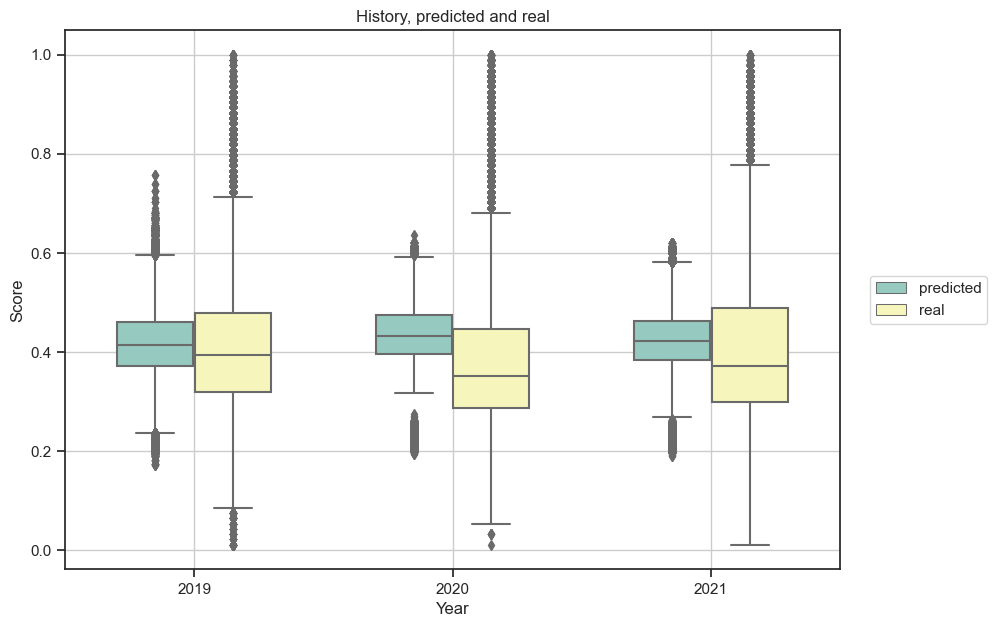

In [77]:

# merge the three dataframes into a single dataframe
df_h = pd.concat([h_2019, h_2020, h_2021], axis=0).rename(columns={'histball':'real', 0:'predicted'})
df_h['Year'] = ['2019']*len(h_2019) + ['2020']*len(h_2020) + ['2021']*len(h_2021)

# melt the dataframe to make it "tidy"
df_melt_h = pd.melt(df_h, id_vars=['Year'], value_vars=['predicted', 'real'], var_name='Type', value_name='Score')
fig = plt.figure(figsize =(10, 7))
# create the boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x='Year', y='Score', hue='Type', data=df_melt_h, palette='Set3', width=0.6)
# Move the hue legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

# customize the plot
plt.title("History, predicted and real")
plt.grid(True)

# show the plot
plt.show()
# Draw a nested boxplot to show bills by day and time



When comparing the predicted distribution and the actual values in a given year, the difference between the median values of the history test changed significantly in 2020 (this happened at the beginning of the lockdown), although a year later in 2021, we can already see that everything is normalizing. Therefore, we can say that the lockdown affected some history teaching or that the tests were of a different difficulty, but only at the initial stage of the lockdown, after which the results began to return to normal.

# English

In [34]:
zno_e = zno2[['year', 'tertypename', 'eoname','regtypename', 
                 'birth', 'sextypename', 'regname', 'engteststatus', 'engball']]
zno_e=zno_e.dropna(axis='rows')
zno_e = zno_e[zno_e['engball'] != 0.0] 
zno_e = zno_e.replace('селище, село', 'село')
zno_e.loc[zno_e['tertypename'] != 'місто', 'tertypename'] = 'село'

In [35]:
zno_e.loc[zno_e["year"] == 2018, 'engball'] = zno_e.loc[zno_e["year"] == 2018]['engball']/ (zno_e.loc[zno_e["year"] == 2018]['engball']).max()
zno_e.loc[zno_e["year"] == 2019, 'engball'] = zno_e.loc[zno_e["year"] == 2019]['engball']/ (zno_e.loc[zno_e["year"] == 2019]['engball']).max()
zno_e.loc[zno_e["year"] == 2020, 'engball'] = zno_e.loc[zno_e["year"] == 2020]['engball']/ (zno_e.loc[zno_e["year"] == 2020]['engball']).max()
zno_e.loc[zno_e["year"] == 2021, 'engball'] = zno_e.loc[zno_e["year"] == 2021]['engball']/ (zno_e.loc[zno_e["year"] == 2021]['engball']).max()
zno_e.head()

,year,tertypename,eoname,regtypename,birth,sextypename,regname,engteststatus,engball
1,2018,місто,Броварська спеціалізована школа І-ІІІ ступенів...,Випускник української школи поточного року,2001,жіноча,Київська область,Зараховано,0.875000
2,2018,місто,Харківська гімназія № 12 Харківської міської р...,Випускник української школи поточного року,2000,жіноча,Харківська область,Зараховано,0.763889
11,2018,місто,Новоград-Волинська загальноосвітня школа І-ІІІ...,Випускник української школи поточного року,2000,жіноча,Житомирська область,Зараховано,0.541667
15,2018,місто,"УМАНСЬКИЙ НАВЧАЛЬНО - ВИХОВНИЙ КОМПЛЕКС ""ЗАГАЛ...",Випускник української школи поточного року,2001,жіноча,Черкаська область,Не подолав поріг,0.152778
24,2018,місто,інше,Випускник минулих років,1999,жіноча,Львівська область,Не подолав поріг,0.250000


In [36]:
zno_e_model = zno_e[['year', 'tertypename', 'eoname', 'regtypename', 
                         'birth', 'sextypename', 'regname', 'engteststatus', 'engball']]
zno_e_model.head()

,year,tertypename,eoname,regtypename,birth,sextypename,regname,engteststatus,engball
1,2018,місто,Броварська спеціалізована школа І-ІІІ ступенів...,Випускник української школи поточного року,2001,жіноча,Київська область,Зараховано,0.875000
2,2018,місто,Харківська гімназія № 12 Харківської міської р...,Випускник української школи поточного року,2000,жіноча,Харківська область,Зараховано,0.763889
11,2018,місто,Новоград-Волинська загальноосвітня школа І-ІІІ...,Випускник української школи поточного року,2000,жіноча,Житомирська область,Зараховано,0.541667
15,2018,місто,"УМАНСЬКИЙ НАВЧАЛЬНО - ВИХОВНИЙ КОМПЛЕКС ""ЗАГАЛ...",Випускник української школи поточного року,2001,жіноча,Черкаська область,Не подолав поріг,0.152778
24,2018,місто,інше,Випускник минулих років,1999,жіноча,Львівська область,Не подолав поріг,0.250000


In [37]:
zno_e_model[['tertypename', 'eoname', 
               'regtypename','sextypename', 
               'regname', 'engteststatus']] = zno_e_model[['tertypename', 'eoname', 
               'regtypename','sextypename', 
               'regname', 'engteststatus']].apply(LabelEncoder().fit_transform)

In [38]:
df_e_2018 = zno_e_model[(zno_e_model['year'] == 2018)]

e_x_train,e_x_test, e_y_train, e_y_test = train_test_split(df_e_2018.drop('engball', axis=1), df_e_2018['engball'], random_state=42, train_size=0.7)


In [39]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [40]:
rf_e=RandomForestRegressor()
rf_random_e = RandomizedSearchCV(estimator = rf_e, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_e.fit(e_x_train, e_y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, verbose=2)

In [41]:
rf_random_e.best_estimator_

RandomForestRegressor(max_depth=60, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=450)

In [78]:
best_random_e = RandomForestRegressor(max_depth=60, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=450)
best_random_e.fit(df_e_2018.drop('engball', axis=1), df_e_2018['engball'])

C:\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=60, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=450)

In [79]:
df_e_2019 = zno_e_model[(zno_e_model['year'] == 2019)]
df_e_2020 = zno_e_model[(zno_e_model['year'] == 2020)]
df_e_2021 = zno_e_model[(zno_e_model['year'] == 2021)]

In [80]:
y_pred_2019_e = best_random_e.predict(df_e_2019.drop('engball', axis=1))
y_pred_2020_e = best_random_e.predict(df_e_2020.drop('engball', axis=1))
y_pred_2021_e = best_random_e.predict(df_e_2021.drop('engball', axis=1))

In [81]:
e_2019 = pd.concat([df_e_2019['engball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2019_e)],axis=1)
e_2020 = pd.concat([df_e_2020['engball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2020_e)],axis=1)
e_2021 = pd.concat([df_e_2021['engball'].reset_index().drop('index', axis=1),pd.Series(y_pred_2021_e)],axis=1)


In [84]:
print(f"Percentage error for 2019 year {mean_absolute_percentage_error(np.array(df_e_2019['engball']), y_pred_2019_e)*100}")
print(f"Percentage error for 2020 year {mean_absolute_percentage_error(np.array(df_e_2020['engball']), y_pred_2020_e)*100}")
print(f"Percentage error for 2021 year {mean_absolute_percentage_error(np.array(df_e_2021['engball']), y_pred_2021_e)*100}")

Percentage error for 2019 year 27.959639184843
Percentage error for 2020 year 32.38471451509694
Percentage error for 2021 year 31.28622209945464


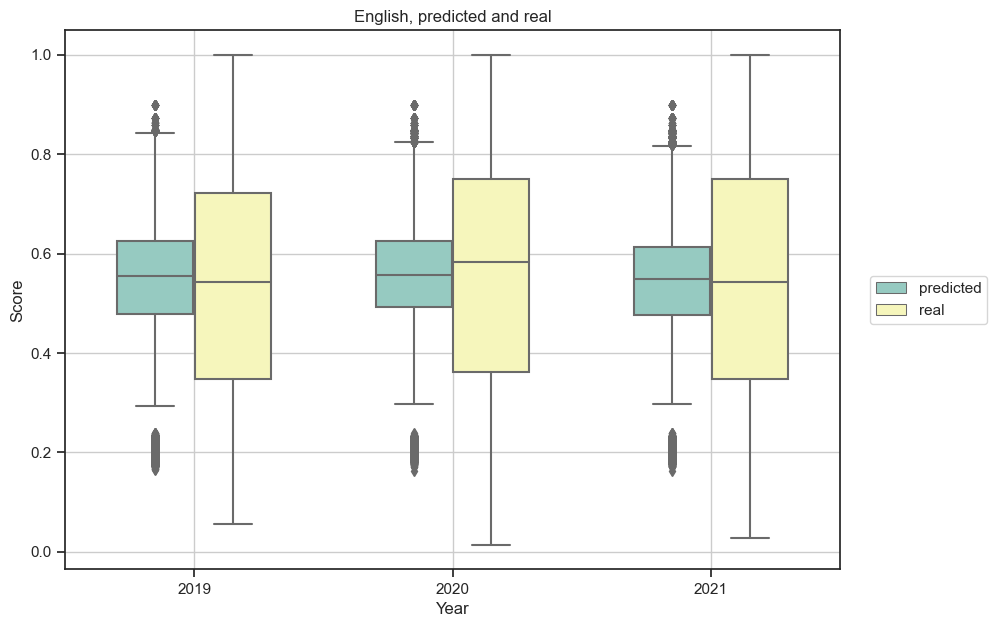

In [86]:

# merge the three dataframes into a single dataframe
df_e = pd.concat([e_2019, e_2020, e_2021], axis=0).rename(columns={'engball':'real', 0:'predicted'})
df_e['Year'] = ['2019']*len(e_2019) + ['2020']*len(e_2020) + ['2021']*len(e_2021)

# melt the dataframe to make it "tidy"
df_melt_e = pd.melt(df_e, id_vars=['Year'], value_vars=['predicted', 'real'], var_name='Type', value_name='Score')
fig = plt.figure(figsize =(10, 7))
# create the boxplot using Seaborn
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x='Year', y='Score', hue='Type', data=df_melt_e, palette='Set3', width=0.6)
# Move the hue legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

# customize the plot
plt.title("English, predicted and real")
plt.grid(True)

# show the plot
plt.show()
# Draw a nested boxplot to show bills by day and time



When comparing the predicted distribution and the actual values in a given year, the difference between the median values of the English test changes very little, which does not allow us to say that the lockdown significantly affected any English teaching or that the tests were of a different complexity.